<a href="https://colab.research.google.com/github/sim-ware/BankTechTest/blob/master/HL7v2_import.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [ ]:
import matplotlib.pyplot as plt

## Pick project

In [ ]:
project_id = 'isla-portal-production' #@param ['portal-dev-e4b9a', 'isla-portal-production']
organisation = 'chelwest'
organisationId = '3onsSeHQkSEiTTBxFL96'
interface = 'hl7V2' #@param ['fhir', 'hl7V2']
bq_dataset_id = organisation+'_'+interface

## Log in

In [ ]:
!gcloud config set project {project_id}
from google.colab import auth
auth.authenticate_user()

Updated property [core/project].


## Load colab table display

In [ ]:
%load_ext google.colab.data_table

# Get all hl7 messages

TODO:
* pull all this out into a tested python lib
* swap out http requests for [Google gRPC client lib](https://cloud.google.com/healthcare/docs/reference/rest/v1beta1/projects.locations.datasets.hl7V2Stores.messages/list)


In [ ]:
import os, requests, pandas as pd

def get_message_pages():
    # START>
    total_message_counter = 0
    # <END
    os.environ["GOOGLE_CLOUD_PROJECT"] = project_id
    token = !gcloud --project={project_id} auth application-default print-access-token
    token = token[0]
    print(f'TEST - TOKEN:{token}')
    print(f'TEST - TOKEN TYPE:{type(token)}')
    page_size = 1000 # max is 1000
    url = f"https://healthcare.googleapis.com/v1/projects/{project_id}/locations/europe-west2/datasets/chelwest-isla/{interface}Stores/chelwest-isla/messages?view=FULL&pageSize={page_size}"
    headers = {"Authorization":f"Bearer {token}"}

    request = requests.get(url, headers=headers)

    while True:
        request.raise_for_status()
        json = request.json()
        # START>
        # here can we check if any messages are after time of ram explosion - only yield then
        time_of_ram_explosion = '2021-03-30T00:00:00Z'
        messages_to_return = list(filter(lambda d: d['sendTime'] > time_of_ram_explosion, json['hl7V2Messages']))
        total_message_counter += len(json['hl7V2Messages'])
        print('START>-------------------------------------------------------------------------------') 
        print(f"Total HL7 Messages so far...: {total_message_counter}")
        print(f"No. of HL7 Messages in this Page: {len(json['hl7V2Messages'])}")
        print(f"First Message sendTime: {json['hl7V2Messages'][0]['sendTime']}")
        print(f"Last Message sendTime: {json['hl7V2Messages'][-1]['sendTime']}")
        print(f"Messages since {time_of_ram_explosion[0:10]} in this Page: {len(messages_to_return)}")
        if (messages_to_return):
          print('OK! - we need to yield these messages!')
          yield json['hl7V2Messages']
        print('---------------------------------------------------------------------------------<END')          
        # <END
        # yield json['hl7V2Messages'] # we now conditionally yield the messages; only if they're after time_of_ram_explosion
        page_token = json.get('nextPageToken')
        if not page_token: break
        request = requests.get(url, params=dict(pageToken=page_token), headers=headers)


messages = pd.DataFrame(m for p in get_message_pages() for m in p)\
    .drop(['data'], axis=1)

# START>
print(f"There are {len(messages)} messages since RAM exploded on -2021-03-30T00:00:00Z- in HL7v2")
messages
# <END

TEST - TOKEN:ya29.a0AfH6SMAG87cBqVeKNp59i5Ak7SCPK16Mpt84yd5Uy5-1lY36IUzsGU6RARD9i2NUVt2GPjZa-Bj3gG8sGiAavi2e5DL34Zn3wivOjNwPirxKBzt-Y8F453UsDL6bOzm9F5V7Z2H7vHjR6hE9_3JSL5T5C6d45SVnhyWC
TEST - TOKEN TYPE:<class 'str'>
START>-------------------------------------------------------------------------------
Total HL7 Messages so far...: 1000
No. of HL7 Messages in this Page: 1000
First Message sendTime: 2020-08-28T13:34:40Z
Last Message sendTime: 2021-01-28T15:16:15Z
Messages since 2021-03-30 in this Page: 0
---------------------------------------------------------------------------------<END


KeyboardInterrupt: ignored

# Parse messages

## Message ID

In [ ]:
messages['id'] = messages.name.map(lambda name: name.split('/')[-1])

## Timestamps

In [ ]:
messages.sendTime = pd.to_datetime(messages.sendTime, utc=True)
messages.createTime = pd.to_datetime(messages.createTime, utc=True)

## Patient NHS number

In [ ]:
def get_nhs_number(ids):
    if ids != ids: return None # ids is nan
    return next((id['value'] for id in ids if id['type'] in ['NHS', 'NHSNMBR']), None)

def get_mrn_number(ids):
    if ids != ids: return None # ids is nan
    return next((id['value'] for id in ids if id['type'] in ['MRN']), None)

messages['nhs_number'] = messages.patientIds.map(get_nhs_number)
messages['mrn'] = messages.patientIds.map(get_mrn_number)
print(f"{messages.nhs_number.notnull().sum()} of {len(messages)} have an NHS number")
messages.sample(1)

173638 of 175428 have an NHS number


,name,sendFacility,sendTime,messageType,createTime,patientIds,parsedData,id,nhs_number,mrn
167727,projects/isla-portal-production/locations/euro...,RQM,2021-04-09 09:11:22+00:00,ADT,2021-04-09 08:11:26.061230+00:00,"[{'value': '02551296', 'type': 'MRN'}, {'value...","{'segments': [{'segmentId': 'MSH', 'fields': {...",2wX9VLeuNnqDi1HUJ0BFGFPf_QDTlaAT_2oPVOLuiqg=,6539905165,02551296


## Message segments


In [ ]:
import re

def matches_field(digit, decimal, k):
    regex = r'{}(\[\d+\])?\.{}'.format(digit, decimal)
    return bool(re.search(regex, k))

def parse_segments(data):
    # index segments by id (list of 2-tuples -> dict of arrays)
    from collections import defaultdict
    segments_by_type = defaultdict(list)

    for segment in data['segments']:
        segments_by_type[segment['segmentId']].append(segment['fields'])

    patient_info = segments_by_type['PID'][0]

    # grab mobile phone no
    for key in patient_info:
        mobile = None
        if matches_field(13, 2, key) and patient_info[key] == 'MOBILE':
            if '[' in key:
                index = re.search(r"\[([A-Za-z0-9_]+)\]", key).group(1)
                mobile = patient_info[f'13[{index}].1']
                break
            else:
                mobile = patient_info['13.1']
                break
    
    # grab email
    email = None
    for key in patient_info:
        if matches_field(11, 7, key) and patient_info[key] == 'EMAIL':
            if '[' in key:
                index = re.search(r"\[([A-Za-z0-9_]+)\]", key).group(1)
                email = patient_info[f'11[{index}].1']
                break
            else:
                email = patient_info['11.1']
                break

    event_type = next(iter(segments_by_type['EVN']), dict()).get('1')
    status = next(iter(segments_by_type['EVN']), dict()).get('4')


    # grab clinic, start and end date
    # if event_type in ['A05', 'A08'] and segments_by_type['PV1']:
    if segments_by_type['PV1']:
        pv1 = segments_by_type['PV1'][0]
        clinic = pv1.get('13', None)
        specialty_code = pv1.get('10')
        start = pv1.get('44', None)
        end = pv1.get('45', None)
        appointment_id = pv1.get('19.1', None)
        
        physician_names = [pv1.get(f'7.{n}') for n in range(7, 1, -1)]
        physician_name = ' '.join(name for name in physician_names if name)
        hospital_3_1 = pv1.get('3.1', None)
        hospital_3_4 = pv1.get('3.4', None)
        hospital_3_7 = pv1.get('3.7', None)
    else:
        clinic = None
        start = None
        end = None
        physician_name = ''
        appointment_id = None 
        specialty_code = None
        status = None
        hospital_3_1 = None
        hospital_3_4 = None
        hospital_3_7 = None

    dob = patient_info.get('7', None)
    
    if dob: dob = dob[:4] + '-' + dob[4:6] + '-' + dob[6:8]

    return dict(
        first_name = patient_info.get('5.2', None),
        last_name = patient_info.get('5.1', None),
        dob = dob,
        mobile = mobile,
        email = email,
        event_type = event_type,
        specialty = specialty_code, #(clinic or '').split(' ')[0],
        clinic = clinic,
        start = pd.to_datetime(start, utc=True),
        end = pd.to_datetime(end, utc=True),
        description = physician_name,
        appointment_id = appointment_id,
        status = status,
        # hospital_3_1 = hospital_3_1,
        hospital = hospital_3_4,
        # hospital_3_7 = hospital_3_7,
    )

def get_parsed():
    return pd.DataFrame(list(messages.parsedData.map(parse_segments)))

# get_parsed().query('event_type == "A"').sample(20)
# get_parsed().sample(50)
# pd.DataFrame(list(messages))


,first_name,last_name,dob,mobile,email,event_type,specialty,clinic,start,end,description,appointment_id,status,hospital
16966,DANIELA,MINGHAM,1987-06-21,07949159144,None,A31,None,None,NaT,NaT,,None,None,None
146356,ALEXANDER,SAGE,1962-05-19,07814004627,None,A31,None,None,NaT,NaT,,None,None,None
105859,GEORGINA,TURNBULL,1944-04-12,07927614034,None,A31,None,None,NaT,NaT,,None,None,None
80266,TIA,HOLLAND,2001-12-06,07852849601,None,A31,None,None,NaT,NaT,,None,None,None
149097,Sarah,Littell,1994-03-15,07507930796,None,A31,None,None,NaT,NaT,,None,None,None
101805,Otto,Ashcroft,2006-12-24,07857667054,None,A31,None,None,NaT,NaT,,None,None,None
32365,ELARI,QUIOGUE,1993-10-21,07531336732,None,A31,None,None,NaT,NaT,,None,None,None
131547,EMMA,CHICHI,1969-10-30,07977101426,None,A31,None,None,NaT,NaT,,None,None,None
36419,Nuno,Sena,1974-08-11,07519878043,None,A31,None,None,NaT,NaT,,None,None,None
16538,CHRISTOPHER,BROWN,1957-08-29,07743698134,None,A31,None,None,NaT,NaT,,None,None,None


In [ ]:
def get_parsed_messages():
    # TODO: change `messages` to function call `get_messages()` so data is always fresh
    return pd.concat([messages, get_parsed()], axis=1)

# get_parsed_messages().sample(1)
# recent_messages.query('event_type == "A05"').head(1)

,name,sendFacility,sendTime,messageType,createTime,patientIds,parsedData,id,nhs_number,mrn,first_name,last_name,dob,mobile,email,event_type,specialty,clinic,start,end,description,appointment_id,status,hospital
154113,projects/isla-portal-production/locations/euro...,RQM,2021-04-08 13:12:41+00:00,ADT,2021-04-08 12:12:57.089411+00:00,"[{'value': '01928441', 'type': 'MRN'}, {'value...","{'segments': [{'segmentId': 'MSH', 'fields': {...",_c5iWATYhydQurj28TDvSaPu2OK_RHEO6ecale6G7sg=,4427613322,01928441,SINEAD,THOMPSON,1991-01-12,07880621068,None,A31,None,None,NaT,NaT,,None,None,None


## Group and parse message groups by nhs number

In [ ]:
def last_valid(column):
    i = column.last_valid_index()
    return i and column.loc[i]

def build_patient(messages):
    messages = messages\
        .rename(columns={
            'nhs_number': 'nhs',
            'first_name': 'firstName',
            'last_name': 'lastName',
            'mobile': 'phone',
            'dob': 'dateOfBirth',
        })[['appointment_id','nhs', 'email', 'firstName', 'lastName', 'phone', 'clinic', 'start', 'end', 'dateOfBirth', 'specialty', 'description', 'mrn', 'hospital']]

    appointment_columns = ['appointment_id', 'clinic', 'start', 'end', 'description', 'hospital']

    patient = messages.apply(last_valid).drop(labels=appointment_columns)
    patient['specialties'] = [s for s in set(messages.specialty.dropna()) if s]
    patient['automatedCreation'] = True

    appointments = messages.groupby('appointment_id')\
        .apply(lambda appointment_messages: appointment_messages.apply(last_valid))
 
    if not appointments.columns.empty:
        appointments = appointments[['nhs',  'specialty'] + appointment_columns]
    
    patient['appointments'] = appointments.to_dict('records')
    patient['hospital_specialty_pairs'] = messages[['specialty', 'hospital']].dropna().drop_duplicates().values.tolist()

    return patient # either with a property of a list of appointments

def get_hl7_patients():
    patients = get_parsed_messages()\
        .groupby('nhs_number')\
        .apply(build_patient)

    return patients[patients.specialty.notnull() & (patients.specialty != '')]\
        .drop(columns=['specialty'])
    return patients

hl7_patients = get_hl7_patients().sort_values('nhs')
print(f"There are {len(hl7_patients)} patients in total")
hl7_patients = hl7_patients.loc[hl7_patients.appointments.map(lambda appts: len(appts) > 0)]
print(f"There are {len(hl7_patients)} with at least 1 appointment")
hl7_patients.sample(3)

There are 2638 patients in total
There are 2638 with at least 1 appointment


,nhs,email,firstName,lastName,phone,dateOfBirth,mrn,specialties,automatedCreation,appointments,hospital_specialty_pairs
nhs_number,,,,,,,,,,,
6287092084,6287092084,None,JABEEN,MOHSIN,07812349666,1947-02-02,01887087,[330],True,"[{'nhs': '6287092084', 'specialty': '330', 'ap...","[[330, CWH]]"
4368463188,4368463188,None,ANIL,PATEL,07939044716,1989-12-09,W734475,[400],True,"[{'nhs': '4368463188', 'specialty': '400', 'ap...","[[400, WMH]]"
4544312035,4544312035,None,Todd,McCann,07854197241,1988-02-28,02740047,[330],True,"[{'nhs': '4544312035', 'specialty': '330', 'ap...","[[330, CWH]]"


In [ ]:
hl7_patients.query('nhs == "4423327813"').head(1).appointments.transpose

<bound method IndexOpsMixin.transpose of Series([], Name: appointments, dtype: object)>

## Patient statistics

(330, CWH)    4878
(330, WMH)    2365
(191, CWH)     952
(161, CWH)     898
(400, CWH)     711
(400, WMH)     693
(653, WMH)     385
(220, CWH)      59
(663, WMH)      17
(653, CWH)      14
(502, CWH)       3
(320, CWH)       2
(241, CWH)       2
(721, CWH)       1
(180, CWH)       1
(103, WMH)       1
(370, CWH)       1
(317, CWH)       1
Name: hospital_specialty_pairs, dtype: int64

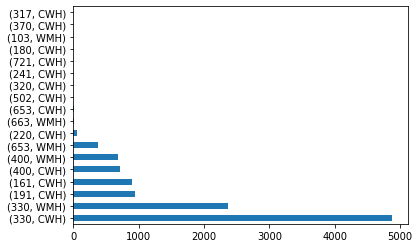

In [ ]:
specialty_counts = hl7_patients.hospital_specialty_pairs.explode().dropna().map(tuple).value_counts()
specialty_counts.plot.barh()
specialty_counts

# Message types over time

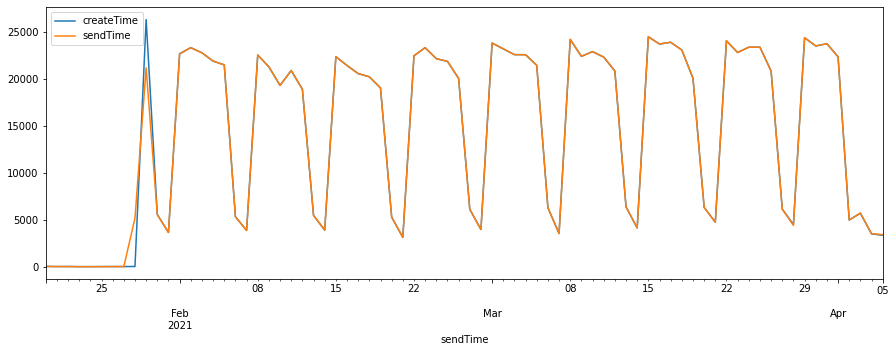

In [ ]:
recent_messages = get_parsed_messages()
# recent_messages = parsed_messages[parsed_messages.createTime > '2021-1-8 09:00']

pd.DataFrame(dict(
    createTime = recent_messages.resample('D', on='createTime').size(),
    sendTime = recent_messages.resample('D', on='sendTime').size(),
)).fillna(0)\
    .loc['2021-1-20':]\
    .plot(figsize=(15, 5))
# recent_messages.resample('D', on='createTime').size().plot(figsize=(15, 5))
# recent_messages.resample('D', on='sendTime').size().plot()
# plt.legend(['createTime', 'sendTime'])

In [ ]:
recent_messages.shape

(1111664, 24)

In [ ]:
recent_messages[recent_messages.createTime > '2021-1-28']

,name,sendFacility,sendTime,messageType,createTime,patientIds,parsedData,id,nhs_number,mrn,first_name,last_name,dob,mobile,email,event_type,specialty,clinic,start,end,description,appointment_id,status,hospital
602,projects/isla-portal-production/locations/euro...,RQM,2021-01-28 07:58:49+00:00,ADT,2021-01-28 07:58:52.296510+00:00,"[{'value': '90100594', 'type': 'MRN'}]","{'segments': [{'segmentId': 'MSH', 'fields': {...",S0jWWfHvFBEUBrdcsjKDPOteZe_Bl6aPgWfPPk8luHw=,None,90100594,TESTKAONE,YYYCWTEST,1997-01-24,None,None,A31,None,None,NaT,NaT,,None,None,None
603,projects/isla-portal-production/locations/euro...,RQM,2021-01-28 07:59:09+00:00,ADT,2021-01-28 07:59:10.482965+00:00,"[{'value': '90100594', 'type': 'MRN'}]","{'segments': [{'segmentId': 'MSH', 'fields': {...",aFr84hOvU9SRBEp0JExtNsey7Q06adZyOhCOZhYm-XU=,None,90100594,TESTKAONE,YYYCWTEST,1997-01-24,None,None,A31,None,None,NaT,NaT,,None,None,None
604,projects/isla-portal-production/locations/euro...,RQM,2021-01-28 08:00:56+00:00,ADT,2021-01-28 08:00:57.457970+00:00,"[{'value': '90100594', 'type': 'MRN'}]","{'segments': [{'segmentId': 'MSH', 'fields': {...",vlt4XvxZ8BEDdvTEc9JinBMd1Basbcv-5C9V8bbEDAc=,None,90100594,TESTKAONE,YYYCWTEST,1997-01-24,None,None,A31,None,None,NaT,NaT,,None,None,None
605,projects/isla-portal-production/locations/euro...,RQM,2021-01-28 08:02:24+00:00,ADT,2021-01-28 08:02:24.947618+00:00,"[{'value': '90100594', 'type': 'MRN'}]","{'segments': [{'segmentId': 'MSH', 'fields': {...",fi5dd0eDcMIcbtzmYCgFPKqStxb1oeElLaCWDs2vFrk=,None,90100594,TESTKAONE,YYYCWTEST,1997-01-24,None,None,A31,None,None,NaT,NaT,,None,None,None
606,projects/isla-portal-production/locations/euro...,RQM,2021-01-28 08:02:25+00:00,ADT,2021-01-28 11:13:26.972793+00:00,"[{'value': '90100594', 'type': 'MRN'}]","{'segments': [{'segmentId': 'MSH', 'fields': {...",IFEexdbYzS9324MyKqE2gI2c8CaW_B5v3SydWEkVpps=,None,90100594,TESTKAONE,YYYCWTEST,1997-01-24,None,None,A08,330,Cardiology New,2021-01-28 08:01:00+00:00,2021-01-28 08:21:00+00:00,,61601267,CHECKIN,CWH
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1111659,projects/isla-portal-production/locations/euro...,RQM,2021-04-05 14:41:20+00:00,ADT,2021-04-05 13:41:21.018971+00:00,"[{'value': '02784338', 'type': 'MRN'}, {'value...","{'segments': [{'segmentId': 'MSH', 'fields': {...",FAjGaoON8Q7kZVVPcAqf56vFjsZ0A2ylSBgEdhISwWc=,7183254313,02784338,SORAYA,ROUX,2017-11-16,07889950481,None,A31,None,None,NaT,NaT,,None,None,None
1111660,projects/isla-portal-production/locations/euro...,RQM,2021-04-05 14:41:26+00:00,ADT,2021-04-05 13:41:27.086484+00:00,"[{'value': '02848239', 'type': 'MRN'}, {'value...","{'segments': [{'segmentId': 'MSH', 'fields': {...",C1nfHz-wtjeJduyD9We1pX6qGEnAmmbdnelmeShLOYI=,7134332306,02848239,Hamada,Mustapha,1988-01-10,07492237330,None,A31,None,None,NaT,NaT,,None,None,None
1111661,projects/isla-portal-production/locations/euro...,RQM,2021-04-05 14:41:28+00:00,ADT,2021-04-05 13:41:29.121442+00:00,"[{'value': 'C443933', 'type': 'MRN'}, {'value'...","{'segments': [{'segmentId': 'MSH', 'fields': {...",Go22LyuzWRI-7008rQzVs6pvBoFk2bpjmOk2LE4xPME=,6224563918,C443933,KULWANT,DHAMI,1958-11-27,07712710335,None,A31,None,None,NaT,NaT,,None,None,None
1111662,projects/isla-portal-production/locations/euro...,RQM,2021-04-05 14:41:38+00:00,ADT,2021-04-05 13:41:38.744359+00:00,"[{'value': '02739571', 'type': 'MRN'}, {'value...","{'segments': [{'segmentId': 'MSH', 'fields': {...",wFT0-_X7G4bgCVG9u7x3ZCG79Ar5ulguefjMTR6eKaM=,7106353639,02739571,Laure,Serruques,1984-08-06,07584671684,None,A31,None,None,NaT,NaT,,None,None,None


In [ ]:
# parsed_messages.event_type.value_counts(dropna=False).plot.barh()
get_parsed().specialty.value_counts(dropna=False).plot.barh()

## Message type samples

A05: Pre-Admit Patient (Patient & appointment)
A08: Update Patient Information (Patient & appointment)
A28: Add Person (Don't seem to be receiving)
A31: Update Person (Patient info only)
A34: merge patient (Don't seem to be receiving yet)

In [ ]:
# recent_messages.query('event_type == "A05"').head(1)
recent_messages.query('nhs_number == "4423327813"').head(2).parsedData.values

In [ ]:
recent_messages.query('event_type == "A08"').head(1)

In [ ]:
recent_messages.query('event_type == "A28"').head(1)

In [ ]:
recent_messages.query('event_type == "A31"').head(1)

In [ ]:
recent_messages.query('event_type == "A34"').head(1)

# Firestore

### Setup

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

# ensure the file is accessible
!ls /content/gdrive/'My Drive'/Isla/serviceAccountKeys/


Mounted at /content/gdrive
development.json  production.json


In [ ]:
import pandas as pd
import firebase_admin
from firebase_admin import credentials, firestore, auth

pd.options.display.max_rows = 120
pd.options.display.max_colwidth = 100

service_account_keys = {
    'portal-dev-e4b9a': 'development',
    'isla-portal-production': 'production',
}

cred_path = "/content/gdrive/My Drive/Isla/serviceAccountKeys/{}.json".format(service_account_keys[project_id])
cred = credentials.Certificate(cred_path)
firebase_admin.initialize_app(cred)

## Query

In [ ]:
store = firestore.client()

def read_collection(name):
    collection = store.collection(name)
    return pd.DataFrame(dict(doc.get().to_dict(), id=doc.id) for doc in collection.list_documents())

def read_collection_group(name):
    collection_group = store.collection_group(name)
    return pd.DataFrame(dict(doc.to_dict(), id=doc.id) for doc in collection_group.stream())

## Patients

In [ ]:
def get_firestore_patients_full():
    return read_collection_group('patients')

def get_firestore_patients():
    firestore_patients_full = get_firestore_patients_full()
    nhs = firestore_patients_full.nhs
    valid_nhs = nhs.notnull() & (nhs != '')

    return firestore_patients_full.loc[
        valid_nhs,
        ['id', 'nhs', 'email', 'teamIds', 'organisationIds', 'firstName', 'lastName', 'phone', 'automatedCreation', 'dateOfBirth','localId']
    ]

firestore_patients = get_firestore_patients()
firestore_patients

,id,nhs,email,teamIds,organisationIds,firstName,lastName,phone,automatedCreation,dateOfBirth,localId
0,000vcXrXZd01ZIuHpjF7,4245232412,NaN,[XiZNRWaTKF5HlY1NUU9l],[PT72dgF8KopuX8vQhgwO],Marc,Duro,-,True,1976-07-21,K0179186
1,004rU36LV2i012JUAFdA,7131537578,NaN,[D8l0Y2ZoJjTWRXROOh6L],[PT72dgF8KopuX8vQhgwO],Mohammad,Talha,07930441234,True,2015-06-10,K3278662
2,00LyyvYoFFqyOScvLvEY,6289960725,NaN,[XBTAd2xjnOiujP0wXZJV],[3onsSeHQkSEiTTBxFL96],Yana,Hraiki,07841 327 719,True,1949-02-17,01288460
3,00OoBTmF1xjCggqBGGwu,4368469356,NaN,[LMrFRrXhOtha3Td4VAtF],[3onsSeHQkSEiTTBxFL96],ARTHUR,BARNES,07541244935,True,1990-08-20,W743182
4,00UxwzJqb77YlCsxx9US,6266281120,NaN,[rjfvRbBGc0PlQkMz1Lfl],[3onsSeHQkSEiTTBxFL96],MUNA,ABDULKADIR,07931328324,True,1989-02-25,01254355
...,...,...,...,...,...,...,...,...,...,...,...
27499,zzQ2Eit41KghL6gw38PG,7128810951,NaN,[],[lG0jxjkicQ5SwQ9guQFc],GINTARAS,STRECKAS,07523708390,True,1967-11-03,80139891
27500,zzpYCsstfIhfhYwWGDeU,4881321455,NaN,[],[lG0jxjkicQ5SwQ9guQFc],FELICIA,HEMAN-ACKAH,07507616648,True,1942-06-11,01889055
27501,zzv4I6KlnQt4RuoChFek,4245373261,NaN,[XiZNRWaTKF5HlY1NUU9l],[PT72dgF8KopuX8vQhgwO],Lee,Allinson,01159771617,True,1985-03-23,K0010499
27502,zzwf30xfVm61FW8g4XUm,4806752347,NaN,[],[lG0jxjkicQ5SwQ9guQFc],RONALD,BERRY,07968134484,True,1962-05-02,01545361


## Appointments

In [ ]:
def get_firestore_appointments():
    # TODO: scope to appointments in this organisation for performance
    firestore_appointments_full = read_collection_group('appointments')
    return firestore_appointments_full

firestore_appointments = get_firestore_appointments()

print(f'There are {len(firestore_appointments)} appointments')
firestore_appointments.sample(2)

There are 27399 appointments


,start,fhirId,patientId,organisationId,updatedAt,createdAt,description,end,specialties,id,automatedCreation,specialty,localId,trustId,name,lastUpdated,fhir_id
14692,2021-02-01 09:40:00+00:00,61984004,XDElO7GCYtdfAJ8Pjmo5,NaN,2021-01-26 22:45:51.149000+00:00,2021-01-26 22:45:51.149000+00:00,"Noy, M",2021-02-01 10:10:00+00:00,[Dermatology],lJAmbuasr6caWUobUUyn,NaN,NaN,NaN,NaN,NaN,NaT,NaN
26204,2021-06-29 14:45:00+00:00,61792773,x87byCCen878go83G4Id,3onsSeHQkSEiTTBxFL96,2021-03-18 14:36:07.656000+00:00,2021-01-26 22:42:56.885000+00:00,,2021-06-29 15:00:00+00:00,[330],Tpf59uZvLTcqZof6kBDu,NaN,330,NaN,NaN,NaN,NaT,NaN


## Teams

In [ ]:
firestore_teams_full = read_collection_group('teams')
firestore_teams_full[firestore_teams_full.organisationId == organisationId]

,isPersonal,name,id,organisationId,members,responseTemplates,specialty,isEmisTeam,hospital
130,NaN,Chelsea - Dermatology - Acne,AoaKX9kkgvZgkPKf27rw,3onsSeHQkSEiTTBxFL96,NaN,[Thanks for your submissions. You might find these links helpful: BAD acne leaflet (https://isl...,NaN,NaN,NaN
192,NaN,Chelsea - Pain Management,Ftghuz6leN98RwTfoAhj,3onsSeHQkSEiTTBxFL96,NaN,NaN,191,NaN,CWH
199,NaN,West Mid Podiatry,GMSeTP0pZuiyS9b4TpvS,3onsSeHQkSEiTTBxFL96,NaN,NaN,653,NaN,WMH
214,NaN,Chelwest Teledermatology Team,HVawBdRXK5GXSyNq7Ktx,3onsSeHQkSEiTTBxFL96,NaN,NaN,NaN,NaN,NaN
222,NaN,Chelsea T&O,IYQa5NKAeJDFc8uMs5il,3onsSeHQkSEiTTBxFL96,NaN,NaN,NaN,NaN,CWH
257,NaN,West Mids - Dermatology,LMrFRrXhOtha3Td4VAtF,3onsSeHQkSEiTTBxFL96,NaN,NaN,330,NaN,WMH
273,NaN,CW Dermatology - Phototherapy,MhGc5upKHPdYTIa9v8N0,3onsSeHQkSEiTTBxFL96,NaN,NaN,NaN,NaN,NaN
284,NaN,Chelsea Paediatric Burns,NPeIuVMVLYSD1GSSaf7Y,3onsSeHQkSEiTTBxFL96,NaN,NaN,220,NaN,CWH
305,NaN,Chelsea - Gibraltar Service,PAlvSjpgxM7y0g2mCW8S,3onsSeHQkSEiTTBxFL96,NaN,NaN,NaN,NaN,NaN
319,NaN,Chelsea - Podiatric Surgery,QMspg0i1lbk9lshp3HXG,3onsSeHQkSEiTTBxFL96,NaN,NaN,653,NaN,CWH


In [ ]:
def get_firestore_teams():
    firestore_teams_full = read_collection_group('teams')

    firestore_teams = firestore_teams_full[firestore_teams_full.organisationId == organisationId]\
        .dropna(subset=['specialty'])\
        .dropna(subset=['hospital'])\
        .drop(columns=['responseTemplates'])\
        .assign(specialty_hospital_pair = lambda teams: [(t.specialty, t.hospital) for _, t in teams.iterrows()])\
        .set_index('specialty_hospital_pair')

    # assert firestore_teams.index.is_unique, f'There is more than one team with the same specialty within organisation {organisationId}'

    return firestore_teams

get_firestore_teams()

,name,isPersonal,id,organisationId,members,specialty,isEmisTeam,hospital
specialty_hospital_pair,,,,,,,,
"(191, CWH)",Chelsea - Pain Management,NaN,Ftghuz6leN98RwTfoAhj,3onsSeHQkSEiTTBxFL96,NaN,191,NaN,CWH
"(653, WMH)",West Mid Podiatry,NaN,GMSeTP0pZuiyS9b4TpvS,3onsSeHQkSEiTTBxFL96,NaN,653,NaN,WMH
"(330, WMH)",West Mids - Dermatology,NaN,LMrFRrXhOtha3Td4VAtF,3onsSeHQkSEiTTBxFL96,NaN,330,NaN,WMH
"(220, CWH)",Chelsea Paediatric Burns,NaN,NPeIuVMVLYSD1GSSaf7Y,3onsSeHQkSEiTTBxFL96,NaN,220,NaN,CWH
"(653, CWH)",Chelsea - Podiatric Surgery,NaN,QMspg0i1lbk9lshp3HXG,3onsSeHQkSEiTTBxFL96,NaN,653,NaN,CWH
"(400, WMH)",West Mid Neurology,NaN,RGpzWeC7cJSIIE2G20qc,3onsSeHQkSEiTTBxFL96,NaN,400,NaN,WMH
"(161, CWH)",Chelsea - Burns,NaN,X36zqP7yhtjyVkAxDnQp,3onsSeHQkSEiTTBxFL96,NaN,161,NaN,CWH
"(330, CWH)",Chelsea - Dermatology,NaN,XBTAd2xjnOiujP0wXZJV,3onsSeHQkSEiTTBxFL96,NaN,330,NaN,CWH
"(663, WMH)",West Mid Podiatric Surgery,NaN,m7Kch4qTgxUrBB5bjm4v,3onsSeHQkSEiTTBxFL96,NaN,663,NaN,WMH


## Check Firestore and HL7 Data Integrity

In [ ]:
firestore_patients_full = get_firestore_patients_full()
nhs = firestore_patients_full.nhs
parsed_messages = get_parsed_messages()

print("There are {} patients in HL7".format(len(parsed_messages)))
print("{} HL7 patient(s) do not have an NHS number, so will not be mapped over".format(parsed_messages.nhs_number.isnull().sum()))
print("{} HL7 patient(s) do not have a mobile, so will not be mapped over".format(parsed_messages.mobile.isnull().sum()))
print("{} HL7 patient(s) do not have an email, so will not be mapped over".format(parsed_messages.email.isnull().sum()))
print("{} HL7 patient(s) do not have a mobile or an email, so will not be mapped over".format((parsed_messages.mobile.isnull() & parsed_messages.email.isnull()).sum()))
print("{} HL7 patient(s) do not have a first name, so will not be mapped over".format(parsed_messages.first_name.isnull().sum()))
print("{} HL7 patient(s) do not have a last name, so will not be mapped over".format(parsed_messages.last_name.isnull().sum()))
print("{} HL7 patient(s) do not have a dob, so will not be mapped over".format(parsed_messages.dob.isnull().sum()))
print()
print("There are {} patient(s) in Firestore".format(len(firestore_patients_full)))
print("{} Firestore patient(s) have null NHS numbers, so will not receive any update".format(nhs.isnull().sum()))
print("{} Firestore patient(s) have blank NHS numbers, so will not receive any update".format((nhs == '').sum()))
print("{} Firestore patient(s) have non-unique NHS numbers, so will not receive any update".format((nhs.notnull() & ~(nhs == '') & nhs.duplicated(keep=False)).sum()))
# Handle HL7 specialities
# Handle Firestore teams
# What do we do if patients are missing mobile phone/emails/dOB?
# -should we strip them out as we won't be able to communicate with them really
# -mobile for text and dOB for authentication

There are 175428 patients in HL7
1790 HL7 patient(s) do not have an NHS number, so will not be mapped over
8597 HL7 patient(s) do not have a mobile, so will not be mapped over
175428 HL7 patient(s) do not have an email, so will not be mapped over
8597 HL7 patient(s) do not have a mobile or an email, so will not be mapped over
10 HL7 patient(s) do not have a first name, so will not be mapped over
10 HL7 patient(s) do not have a last name, so will not be mapped over
0 HL7 patient(s) do not have a dob, so will not be mapped over

There are 26111 patient(s) in Firestore
1 Firestore patient(s) have null NHS numbers, so will not receive any update
495 Firestore patient(s) have blank NHS numbers, so will not receive any update
1699 Firestore patient(s) have non-unique NHS numbers, so will not receive any update


# Update Firestore

Plan to get started:
* first, just add patients from messages that have both an nhs_number and a clinic i.e. A05 messages
* then group messages by nhs_number, perform an aggregation of patient and appointment info across the messages
* create or update patient and appointment info based on the aggregation

## Patients

In [ ]:
def get_patients():
    # patients = pd.merge(get_hl7_patients(), get_firestore_patients(), how='outer', left_on='nhs', right_on='nhs', suffixes=('_hl7', '_firestore'), indicator=True)\
    patients = pd.merge(hl7_patients, get_firestore_patients(), how='outer', left_on='nhs', right_on='nhs', suffixes=('_hl7', '_firestore'), indicator=True)\
        .drop_duplicates(subset='nhs', keep=False)

    firestore_teams = get_firestore_teams()
    patients['teamIdsToAdd'] = patients.hospital_specialty_pairs.dropna().map(lambda pairs: [firestore_teams.id.get(tuple(pair)) for pair in pairs if tuple(pair) in firestore_teams.id])
    return patients

patients = get_patients()
patients.head(3)

,nhs,email_hl7,firstName_hl7,lastName_hl7,phone_hl7,dateOfBirth_hl7,mrn,specialties,automatedCreation_hl7,appointments,hospital_specialty_pairs,id,email_firestore,teamIds,organisationIds,firstName_firestore,lastName_firestore,phone_firestore,automatedCreation_firestore,dateOfBirth_firestore,localId,_merge,teamIdsToAdd
0,4000130048,None,CHRISTOPHER,DIGBY-BELL,07770777399,1948-06-21,00813225,[330],True,"[{'nhs': '4000130048', 'specialty': '330', 'appointment_id': '62282134', 'clinic': 'Derm Penile ...","[[330, CWH]]",3wIk0i5uww4UQHTqeAHo,NaN,[XBTAd2xjnOiujP0wXZJV],[3onsSeHQkSEiTTBxFL96],CHRISTOPHER,DIGBY-BELL,07770777399,True,1948-06-21,00813225,both,[XBTAd2xjnOiujP0wXZJV]
1,4000282808,None,JAMES,SMITH,07903664614,1946-12-04,80128541,[400],True,"[{'nhs': '4000282808', 'specialty': '400', 'appointment_id': '62303990', 'clinic': 'Neurology Ne...","[[400, CWH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[rjfvRbBGc0PlQkMz1Lfl]
2,4001075466,None,ROSS,LIPSETT,07765890445,1951-12-15,C210045,[330],True,"[{'nhs': '4001075466', 'specialty': '330', 'appointment_id': '62203881', 'clinic': 'Derm F/Up', ...","[[330, WMH]]",x8d4SClQASYoLJJmkw7E,NaN,[LMrFRrXhOtha3Td4VAtF],[3onsSeHQkSEiTTBxFL96],ROSS,LIPSETT,07765890445,True,1951-12-15,C210045,both,[LMrFRrXhOtha3Td4VAtF]


### Create New Patients

In [ ]:
# patients_to_add = get_patients()
patients_to_add = patients
patients_to_add = patients_to_add.loc[
    (patients_to_add._merge == 'left_only') 
    # (patients_to_add.teamIdsToAdd.map(lambda ids: len(ids) > 0))
]
print('There are {} patients to add'.format(len(patients_to_add)))
patients_to_add.head(30)

There are 1203 patients to add


,nhs,email_hl7,firstName_hl7,lastName_hl7,phone_hl7,dateOfBirth_hl7,mrn,specialties,automatedCreation_hl7,appointments,hospital_specialty_pairs,id,email_firestore,teamIds,organisationIds,firstName_firestore,lastName_firestore,phone_firestore,automatedCreation_firestore,dateOfBirth_firestore,localId,_merge,teamIdsToAdd
1,4000282808,None,JAMES,SMITH,07903664614,1946-12-04,80128541,[400],True,"[{'nhs': '4000282808', 'specialty': '400', 'appointment_id': '62303990', 'clinic': 'Neurology Ne...","[[400, CWH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[rjfvRbBGc0PlQkMz1Lfl]
7,4001917106,None,THOMAS,DAY,07950747472,1942-11-30,01737249,[191],True,"[{'nhs': '4001917106', 'specialty': '191', 'appointment_id': '62281357', 'clinic': 'Pain Mgt Tel...","[[191, CWH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[Ftghuz6leN98RwTfoAhj]
8,4001956438,None,PAUL,HEGARTY,07961871918,1955-04-24,01693922,[330],True,"[{'nhs': '4001956438', 'specialty': '330', 'appointment_id': '62298178', 'clinic': 'Pre Assessme...","[[330, CWH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[XBTAd2xjnOiujP0wXZJV]
9,4001967626,None,ANN,FAROOQ,07930666955,1943-08-14,W558011,[161],True,"[{'nhs': '4001967626', 'specialty': '161', 'appointment_id': '62296243', 'clinic': 'Burns Dressi...","[[161, CWH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[X36zqP7yhtjyVkAxDnQp]
14,4003829379,None,Douglas,GARDNER,07941176070,1943-12-20,01735409,[400],True,"[{'nhs': '4003829379', 'specialty': '400', 'appointment_id': '62016447', 'clinic': 'Neurology F/...","[[400, CWH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[rjfvRbBGc0PlQkMz1Lfl]
15,4003865723,None,ALASTAIR,SEGGIE,07860579974,1968-07-19,C653182,[400],True,"[{'nhs': '4003865723', 'specialty': '400', 'appointment_id': '62293167', 'clinic': 'Neuro Epilep...","[[400, WMH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[RGpzWeC7cJSIIE2G20qc]
18,4005481108,None,Peter,Nightingale,None,1942-07-22,C333542,[330],True,"[{'nhs': '4005481108', 'specialty': '330', 'appointment_id': '62291435', 'clinic': 'Derm New', '...","[[330, WMH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[LMrFRrXhOtha3Td4VAtF]
19,4005726321,None,ROSE-MARIE,HARVEY,07494920762,1946-05-29,00756564,[191],True,"[{'nhs': '4005726321', 'specialty': '191', 'appointment_id': '62275814', 'clinic': 'Adult Pre As...","[[191, CWH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[Ftghuz6leN98RwTfoAhj]
21,4006354312,None,GEORGINA,HINGLE,07742118532,1923-02-02,01237445,[330],True,"[{'nhs': '4006354312', 'specialty': '330', 'appointment_id': '62303847', 'clinic': 'Derm Teleder...","[[330, CWH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[XBTAd2xjnOiujP0wXZJV]
27,4008196293,None,RAYMOND,AMES,None,1938-04-16,C533124,[330],True,"[{'nhs': '4008196293', 'specialty': '330', 'appointment_id': '62304304', 'clinic': 'Derm F/Up', ...","[[330, WMH]]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only,[LMrFRrXhOtha3Td4VAtF]


In [ ]:
hospital_specialty_pairs_with_no_matching_firestore_team = set(patients_to_add.hospital_specialty_pairs.explode().dropna().map(tuple)) - set(get_firestore_teams().index)
if hospital_specialty_pairs_with_no_matching_firestore_team:
    print(f"The following hospital specialty pairs have no matching team in Firestore: {hospital_specialty_pairs_with_no_matching_firestore_team}")

The following hospital specialty pairs have no matching team in Firestore: {('191', 'WMH'), ('171', 'CWH'), ('171', 'WMH')}


In [ ]:
for _, patient in patients_to_add.iterrows():
    patient_data = dict(
        firstName=patient.firstName_hl7,
        lastName=patient.lastName_hl7,
        dateOfBirth=patient.dateOfBirth_hl7,
        nhs=patient.nhs,
        phone=patient.phone_hl7,
        teamIds=patient.teamIdsToAdd,
        createdAt=firestore.SERVER_TIMESTAMP,
        # updatedAt=firestore.SERVER_TIMESTAMP,
        lastUpdated=firestore.SERVER_TIMESTAMP,
        requiresAttention=False,
        localId=patient.mrn, # maybe put MRN in here
        organisationIds=[organisationId],
        automatedCreation=True,
        isArchived=False,
    )
    print(patient)
    store.collection('patients').add(patient_data)


Streaming output truncated to the last 5000 lines.
lastName_firestore                                                                                                             NaN
phone_firestore                                                                                                                NaN
automatedCreation_firestore                                                                                                    NaN
dateOfBirth_firestore                                                                                                          NaN
localId                                                                                                                        NaN
_merge                                                                                                                   left_only
teamIdsToAdd                                                                                                [XBTAd2xjnOiujP0wXZJV]
Name: 2342, dtype: object
nhs   

### Update Existing Patients

In [ ]:
def valid_phone(phone):
    if not phone: return False
    
    digits = ''.join(ch for ch in phone if ch in '0123456789')
    return digits.startswith('07') or digits.startswith('447')

patients_to_update = get_patients().query("_merge == 'both'").assign(
    firstName_matches = lambda patients: (patients.firstName_hl7 == patients.firstName_firestore) | patients.firstName_hl7.isnull(),
    dob_matches = lambda patients: (patients.dateOfBirth_hl7 == patients.dateOfBirth_firestore) | patients.dateOfBirth_hl7.isnull(),
    lastName_matches = lambda patients: (patients.lastName_hl7 == patients.lastName_firestore) | patients.lastName_hl7.isnull(),
    phone_matches = lambda patients: (patients.phone_hl7 == patients.phone_firestore) | patients.phone_hl7.isnull(),
    valid_phone_hl7 = lambda patients: patients.phone_hl7.map(valid_phone),
    teamIds_match = lambda patients: patients.teamIds == patients.teamIdsToAdd,
    # organisationIds_match = lambda patients: patients.organisationIds == [organisationId],
    localIds_match = lambda patients: patients.mrn == patients.localId
)
patients_to_update['all_fields_match'] = patients_to_update.firstName_matches & patients_to_update.lastName_matches & patients_to_update.phone_matches & patients_to_update.dob_matches & patients_to_update.localIds_match & patients_to_update.teamIds_match
print('There are {} patients in both hl7 and Firestore'.format(len(patients_to_update)))
print('There are {} patients which have differing details and need to be updated'.format(len(patients_to_update.query('not all_fields_match'))))
# print("{} patients do not have a specialty, so will not be mapped over")
patients_to_update = patients_to_update.query('not all_fields_match')
patients_to_update.sample(5)

There are 2557 patients in both hl7 and Firestore
There are 392 patients which have differing details and need to be updated


,nhs,email_hl7,firstName_hl7,lastName_hl7,phone_hl7,dateOfBirth_hl7,mrn,specialties,automatedCreation_hl7,appointments,hospital_specialty_pairs,id,email_firestore,teamIds,organisationIds,firstName_firestore,lastName_firestore,phone_firestore,automatedCreation_firestore,dateOfBirth_firestore,localId,_merge,teamIdsToAdd,firstName_matches,dob_matches,lastName_matches,phone_matches,valid_phone_hl7,teamIds_match,localIds_match,all_fields_match
2178,7008378300,None,BENJAMIN,LAW,None,2003-09-12,80177457,[330],True,"[{'nhs': '7008378300', 'specialty': '330', 'appointment_id': '62031689', 'clinic': 'Derm Acne Ne...","[[330, CWH]]",z9MaKNkIssDuRPy1YIbF,NaN,[AoaKX9kkgvZgkPKf27rw],[3onsSeHQkSEiTTBxFL96],BENJAMIN,LAW,00000000000,True,2003-09-12,80177457,both,[XBTAd2xjnOiujP0wXZJV],True,True,True,True,False,False,True,False
2291,7057819307,None,Ester,Shabani,07920091030,1994-05-13,02787687,[330],True,"[{'nhs': '7057819307', 'specialty': '330', 'appointment_id': '62209878', 'clinic': 'Derm Acne Ne...","[[330, CWH]]",sMIjjavqjIOd3ca9cP4i,NaN,[XBTAd2xjnOiujP0wXZJV],[3onsSeHQkSEiTTBxFL96],ESTER,SHABANI,07920091030,True,1994-05-13,02787687,both,[XBTAd2xjnOiujP0wXZJV],False,True,False,True,True,True,True,False
665,4442332495,None,SHAZIA,ASGHAR,07711272728,1979-07-22,C618420,[330],True,"[{'nhs': '4442332495', 'specialty': '330', 'appointment_id': '61653031', 'clinic': 'Derm Acne F/...","[[330, CWH]]",lAAEffGtHIc8rqXn1XAY,NaN,[AoaKX9kkgvZgkPKf27rw],[3onsSeHQkSEiTTBxFL96],SHAZIA,ASGHAR,07711272728,True,1979-07-22,C618420,both,[XBTAd2xjnOiujP0wXZJV],True,True,True,True,True,False,True,False
579,4407225742,None,SHERIECE,FORDE,07534205838,1987-07-26,80105162,[330],True,"[{'nhs': '4407225742', 'specialty': '330', 'appointment_id': '61953889', 'clinic': 'Derm Acne F/...","[[330, CWH]]",S1hJqpWqeNrQfihFTjo2,NaN,[AoaKX9kkgvZgkPKf27rw],[3onsSeHQkSEiTTBxFL96],Sheriece,Forde,+447534205838,NaN,1987-07-26,NaN,both,[XBTAd2xjnOiujP0wXZJV],False,True,False,False,True,False,False,False
2495,7167467669,None,Paula,Cretu,07447962650,1992-01-09,80038233,[330],True,"[{'nhs': '7167467669', 'specialty': '330', 'appointment_id': '62306982', 'clinic': 'Derm Biopsy ...","[[330, WMH]]",v171ixiFrcpLEMvGw9ur,NaN,[LMrFRrXhOtha3Td4VAtF],[3onsSeHQkSEiTTBxFL96],Paula,CRETU,+447447962650,NaN,1992-01-09,,both,[LMrFRrXhOtha3Td4VAtF],True,True,False,False,True,True,False,False


In [ ]:
for _, patient in patients_to_update.iterrows():
    patient_data = dict(
        firstName=patient.firstName_hl7,
        lastName=patient.lastName_hl7,
        dateOfBirth=patient.dateOfBirth_hl7,
        phone=patient.phone_hl7,
        # updatedAt=firestore.SERVER_TIMESTAMP,
        lastUpdated=firestore.SERVER_TIMESTAMP,
        localId=patient.mrn,
        organisationIds=firestore.ArrayUnion([organisationId]),
        automatedCreation=True,
    )
    if patient.teamIdsToAdd:
        patient_data['teamIds'] = firestore.ArrayUnion(patient.teamIdsToAdd)
        
    print(patient_data)
    store.collection('patients').document(patient.id).update(patient_data)

{'firstName': 'ANNA', 'lastName': 'YAFAOUI', 'dateOfBirth': '1963-10-16', 'phone': '07887480327', 'lastUpdated': Sentinel: Value used to set a document field to the server timestamp., 'localId': '02745428', 'organisationIds': <google.cloud.firestore_v1.transforms.ArrayUnion object at 0x7f93225fbad0>, 'automatedCreation': True, 'teamIds': <google.cloud.firestore_v1.transforms.ArrayUnion object at 0x7f93225fbd90>}
{'firstName': 'KAREN', 'lastName': 'MORRIS', 'dateOfBirth': '1967-09-09', 'phone': '07919355716', 'lastUpdated': Sentinel: Value used to set a document field to the server timestamp., 'localId': 'C035662', 'organisationIds': <google.cloud.firestore_v1.transforms.ArrayUnion object at 0x7f9322602350>, 'automatedCreation': True, 'teamIds': <google.cloud.firestore_v1.transforms.ArrayUnion object at 0x7f936daf6d90>}
{'firstName': 'LORRAINE', 'lastName': 'KEGGIE', 'dateOfBirth': '1955-07-09', 'phone': '07798585686', 'lastUpdated': Sentinel: Value used to set a document field to the s

 ### Merge patients

## Appointments

In [ ]:
def get_hl7_appointments():
    # get patientId from Firestore patients via nhs number
    firestore_patient_ids_by_nhs = get_firestore_patients().set_index('nhs').id.rename('patientId')

    appointments = hl7_patients.appointments.explode().apply(pd.Series)\

    return hl7_patients\
        .join(firestore_patient_ids_by_nhs, on='nhs')\
        [['patientId']]\
        .join(appointments, how='outer', lsuffix='_pnt', rsuffix='_appt')

# get_hl7_appointments().head(1).transpose().sort_index()
get_hl7_appointments().sample(10)

,patientId,nhs,specialty,appointment_id,clinic,start,end,description,hospital
nhs_number,,,,,,,,,
6484771731,uQslNuj5pjC2wippW4MH,6484771731,161,62278030,Ward Attender F/Up,2021-04-02 15:00:00+00:00,2021-04-02 16:00:00+00:00,Isabel Jones,CWH
6310409417,jKhduN7eekU6TTTxLlRA,6310409417,330,62286052,Derm SWAB F/Up,2021-05-21 10:30:00+00:00,2021-05-21 10:45:00+00:00,,WMH
4866610409,LifXd3mhFa4jhmXQAqMU,4866610409,330,62285963,Derm Tel F/Up,2021-04-06 12:00:00+00:00,2021-04-06 12:15:00+00:00,Gayathri Perera,WMH
4541051117,hyc84j6eweMlHHMBE6C3,4541051117,330,62286269,Pre Assessment F/Up,2021-04-12 14:15:00+00:00,2021-04-12 15:00:00+00:00,Mariana Noy,CWH
7122597237,mwgKUHToFBCR5P5jW3c9,7122597237,330,62213496,Derm Acne F/Up,2021-04-06 15:15:00+00:00,2021-04-06 15:30:00+00:00,,CWH
6366609284,1DwsUZZiMY3pcnLruvAe,6366609284,161,62298148,Burns F/Up,2021-06-30 16:30:00+00:00,2021-06-30 16:40:00+00:00,Joanne Atkins,CWH
4349512284,MROqojwKp9ftWQbCwRDG,4349512284,653,62253691,Podiatry F/Up,2021-04-13 15:45:00+00:00,2021-04-13 16:00:00+00:00,Sally Feeney,WMH
4021257756,KuDzd4M1r1KoOiSzBlXj,4021257756,161,62284735,Burns Dressing F/Up,2021-04-06 08:30:00+00:00,2021-04-06 08:50:00+00:00,,CWH
4907230575,jZdY45LtrAIQSZFxafXr,4907230575,400,62302150,Neurology New,2021-06-07 10:30:00+00:00,2021-06-07 11:00:00+00:00,Rabeha Zemmouri,WMH


In [ ]:
def get_appointments():
    return pd.merge(
        get_hl7_appointments(),
        get_firestore_appointments(),
        how='outer',
        left_on='appointment_id',
        right_on='fhirId',
        suffixes=('_hl7', '_firestore'),
        indicator=True,
    )

appointments = get_appointments()
appointments.sample(3)

,patientId_hl7,nhs,specialty_hl7,appointment_id,clinic,start_hl7,end_hl7,description_hl7,hospital,description_firestore,end_firestore,specialties,start_firestore,fhirId,patientId_firestore,organisationId,updatedAt,createdAt,id,localId,automatedCreation,specialty_firestore,trustId,name,lastUpdated,fhir_id,_merge
4948,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,,2021-07-28 10:15:00+00:00,[330],2021-07-28 10:00:00+00:00,62082604,2e4a5kT3NdU8uqJLjIle,3onsSeHQkSEiTTBxFL96,2021-03-03 15:49:18.794000+00:00,2021-02-05 11:12:47.264000+00:00,ZGrVE4JlPoDO7y01F1sL,NaN,True,330,NaN,NaN,NaT,NaN,right_only
22733,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,Q-JCR1R General Paed Dermatology,2021-04-19 10:20:00+00:00,[Paediatric Dermatology],2021-04-19 10:20:00+00:00,a43e5b18-4cb7-4c16-a5cc-84b79ae19b5d,hWBScZziREOOJ5xtC2nk,PT72dgF8KopuX8vQhgwO,2021-03-23 13:30:35.796000+00:00,2021-03-23 13:30:35.796000+00:00,nJ5ZGmvagDAFpne9oTqR,NaN,NaN,NaN,NaN,NaN,NaT,NaN,right_only
25890,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,"Q-MFOSN Epilepsy Spec. Nurse O'Donoghue,M",2021-05-07 09:30:00+00:00,[Neurology],2021-05-07 09:30:00+00:00,K1328485,p3gacvh6EHwi3oEJq11B,PT72dgF8KopuX8vQhgwO,2020-12-02 21:17:38.617000+00:00,2020-12-02 21:17:38.617000+00:00,DdE3nEQLDvfIWdEem9hV,NaN,NaN,NaN,NaN,NaN,NaT,NaN,right_only


### Create new appointments

In [ ]:
appointments_to_add = appointments[appointments._merge == 'left_only']
print('There are {} appointments to add'.format(len(appointments_to_add)))
appointments_to_add.sample(1).transpose()

There are 2820 appointments to add


,1907
patientId_hl7,BjHfM4WYPFK3Qxk5VfYj
nhs,6241289578
specialty_hl7,330
appointment_id,62291976
clinic,Derm Telederm New
start_hl7,2021-04-15 11:00:00+00:00
end_hl7,2021-04-15 11:15:00+00:00
description_hl7,Chrystalla Macedo
hospital,CWH
description_firestore,NaN


In [ ]:
for _, appointment in appointments_to_add.iterrows():
    patient_id = appointment.patientId_hl7
    if not patient_id:
        print('skipping because patient_id is missing')
        continue

    appointment_data = dict(
        createdAt=firestore.SERVER_TIMESTAMP,
        # lastUpdated=firestore.SERVER_TIMESTAMP, # should this be 'updatedAt'?
        updatedAt=firestore.SERVER_TIMESTAMP,
        start=appointment.start_hl7,
        end=appointment.end_hl7,
        patientId=patient_id,
        localId=appointment.appointment_id,
        fhirId=appointment.appointment_id, 
        description=appointment.description_hl7,
        specialty=appointment.specialty_hl7,
        specialties=[appointment.specialty_hl7],
        organisationId = organisationId,
        automatedCreation=True,
    )
    print(appointment_data)
    store.collection('patients').document(patient_id).collection('appointments').add(appointment_data)

{'createdAt': Sentinel: Value used to set a document field to the server timestamp., 'updatedAt': Sentinel: Value used to set a document field to the server timestamp., 'start': Timestamp('2021-06-09 14:30:00+0000', tz='UTC'), 'end': Timestamp('2021-06-09 14:45:00+0000', tz='UTC'), 'patientId': '3wIk0i5uww4UQHTqeAHo', 'localId': '62282134', 'fhirId': '62282134', 'description': '', 'specialty': '330', 'specialties': ['330'], 'organisationId': '3onsSeHQkSEiTTBxFL96', 'automatedCreation': True}
{'createdAt': Sentinel: Value used to set a document field to the server timestamp., 'updatedAt': Sentinel: Value used to set a document field to the server timestamp., 'start': Timestamp('2021-06-17 10:00:00+0000', tz='UTC'), 'end': Timestamp('2021-06-17 10:30:00+0000', tz='UTC'), 'patientId': 'urJj4DDKw2r230rrtXxw', 'localId': '62303990', 'fhirId': '62303990', 'description': 'Helen Grote', 'specialty': '400', 'specialties': ['400'], 'organisationId': '3onsSeHQkSEiTTBxFL96', 'automatedCreation': T

### Remove Duplicated Appointments

In [ ]:
df = get_firestore_appointments()
df.fhirId.value_counts().sort_values()


4cef781e-c514-4e15-b86e-4511492bb7c5    1
62286061                                1
62120662                                1
62178308                                1
62255921                                1
                                       ..
62094994                                6
62102311                                6
62084354                                6
62102351                                6
62013859                                6
Name: fhirId, Length: 28496, dtype: int64

### Update Existing Appointments

In [ ]:
appointments.sample(10)

,patientId_hl7,nhs,specialty_hl7,appointment_id,clinic,start_hl7,end_hl7,description_hl7,hospital,description_firestore,end_firestore,specialties,start_firestore,fhirId,patientId_firestore,organisationId,updatedAt,createdAt,id,localId,automatedCreation,specialty_firestore,trustId,name,lastUpdated,fhir_id,_merge
22199,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,"C-MFO30 Neurology O'Donoghue,M",2020-12-09 16:00:00+00:00,[Neurology],2020-12-09 16:00:00+00:00,K1221638,gJQt98izxvuDan4zyGIv,PT72dgF8KopuX8vQhgwO,2020-12-02 21:13:57.725000+00:00,2020-12-02 21:13:57.725000+00:00,oCPNv8EYrOGrobpkh248,NaN,NaN,NaN,NaN,NaN,NaT,NaN,right_only
25500,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,Nicholas Davies,2021-10-01 14:30:00+00:00,[400],2021-10-01 14:00:00+00:00,62266525,o8OrASa4qsi6S1cYUPB9,3onsSeHQkSEiTTBxFL96,2021-03-29 12:42:56.549000+00:00,2021-03-29 12:42:56.549000+00:00,bXGP4jvXwsXyFOFf5DNl,62266525,True,400,NaN,NaN,NaT,NaN,right_only
27037,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,,2021-05-20 11:00:00+00:00,[330],2021-05-20 10:45:00+00:00,61661068,rqE1Fxtk98494qpFwSzi,3onsSeHQkSEiTTBxFL96,2021-03-03 15:48:51.272000+00:00,2021-01-26 22:49:04.732000+00:00,JzuKoHmaxCsnc0tcS0vL,NaN,NaN,330,NaN,NaN,NaT,NaN,right_only
20050,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,"Q-3SS5A Epilepsy Singhal,S",2021-04-16 10:45:00+00:00,[Neurology],2021-04-16 10:45:00+00:00,6a5f7b26-7e00-41ad-9c03-0ff8ba0c8610,bMjZ3IQPtpXHX98MUxGk,PT72dgF8KopuX8vQhgwO,2021-01-28 13:28:06.135000+00:00,2021-01-28 13:28:06.135000+00:00,zi1gho8L9CQzIRlsZnLI,NaN,NaN,NaN,NaN,NaN,NaT,NaN,right_only
15147,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,"Q-MFOSN Epilepsy Spec. Nurse O'Donoghue,M",2021-02-01 11:00:00+00:00,[Neurology],2021-02-01 11:00:00+00:00,K3416710,PvKgkpGvcXDCs86urMta,PT72dgF8KopuX8vQhgwO,2020-12-02 21:15:48.328000+00:00,2020-12-02 21:15:48.328000+00:00,7bY8ONYKTTUuy6yjxTTN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,right_only
16168,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,"Q-TST4A Paed Dermatology Tang,K",2020-11-05 09:00:00+00:00,[Paediatric Dermatology],2020-11-05 09:00:00+00:00,37680ef9-3940-4515-b34b-54a5593ada27,SKNvgmCYkkrUNN393Df6,PT72dgF8KopuX8vQhgwO,2020-11-02 07:51:34.273000+00:00,2020-11-02 07:51:34.273000+00:00,wTMBUVhm9nmw7WkeqIiy,NaN,NaN,NaN,NaN,NaN,NaT,NaN,right_only
18481,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,Isabel Jones,2021-02-27 15:00:00+00:00,[220],2021-02-27 14:00:00+00:00,62170460,XoV7xeuOaq4oQU7GUxZs,3onsSeHQkSEiTTBxFL96,2021-03-01 10:52:41.819000+00:00,2021-03-01 10:52:41.819000+00:00,PoKvZZxTWaJ5JQdoxfXx,62170460,True,220,NaN,NaN,NaT,NaN,right_only
18593,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,Chrystalla Macedo,2021-04-09 09:45:00+00:00,[330],2021-04-09 09:30:00+00:00,61686055,Y5uRLT7nucIwrDIG3kX9,3onsSeHQkSEiTTBxFL96,2021-02-25 16:03:27.107000+00:00,2021-02-25 16:03:27.107000+00:00,b2ipBU5sVWYqO6yyA05Q,61686055,True,330,NaN,NaN,NaT,NaN,right_only
8788,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,,2020-12-02 15:10:00+00:00,[161],2020-12-02 15:00:00+00:00,61854103,BIyogZGe8kIr0Y7765A7,3onsSeHQkSEiTTBxFL96,2021-02-25 16:07:22.009000+00:00,2021-02-25 16:07:22.009000+00:00,JD7ThSLd5cycOLuYXPpc,61854103,True,161,NaN,NaN,NaT,NaN,right_only
1298,q0hl9ZnR19ld8jYrXeHx,4740205548,400,62277093,Neurology F/Up,2021-10-26 09:30:00+00:00,2021-10-26 09:45:00+00:00,Ronald Pearce,WMH,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaN,left_only


There are 3811 appointments in both hl7 and Firestore
There are 584 appointments which have differing details and need to be updated


,patientId_hl7,nhs,specialty_hl7,appointment_id,clinic,start_hl7,end_hl7,description_hl7,hospital,organisationId,updatedAt,createdAt,description_firestore,end_firestore,specialties,start_firestore,patientId_firestore,fhirId,id,automatedCreation,specialty_firestore,localId,trustId,name,lastUpdated,fhir_id,_merge,description_matches,start_matches,end_matches,specialty_matches,id_matches,all_fields_match
1875,3vH6xe5N2E3GtKf2i25z,6203451576,330,61792263,Derm New,2021-04-23 10:00:00+00:00,2021-04-23 10:15:00+00:00,Gayathri Perera,WMH,NaN,2021-01-26 22:49:54.785000+00:00,2021-01-26 22:49:54.785000+00:00,"Emam, R",2021-03-12 10:00:00+00:00,[Dermatology],2021-03-12 09:45:00+00:00,3vH6xe5N2E3GtKf2i25z,61792263,qBFmIzCDIm8GhMhB88vF,NaN,NaN,NaN,NaN,NaN,NaT,NaN,both,False,False,False,False,True,False
2154,Hje6mImXZ9xkQZ66V6j7,6281293894,330,61526876,Derm F/Up,2021-06-18 16:15:00+00:00,2021-06-18 16:30:00+00:00,,WMH,NaN,2021-01-26 22:46:49.499000+00:00,2021-01-26 22:46:49.499000+00:00,"Akel, R",2021-05-19 16:30:00+00:00,[Dermatology],2021-05-19 16:15:00+00:00,Hje6mImXZ9xkQZ66V6j7,61526876,x887TxL8qFV0P9rH4SI7,NaN,NaN,NaN,NaN,NaN,NaT,NaN,both,False,False,False,False,True,False
308,jNUw3EjkyB6YuwJEAcOk,4262810623,191,62072168,Pain Mgt F/Up,2021-05-11 10:30:00+00:00,2021-05-11 11:15:00+00:00,Ian Goodall,CWH,3onsSeHQkSEiTTBxFL96,2021-03-05 13:18:17.855000+00:00,2021-02-25 16:00:20.600000+00:00,Ian Goodall,2021-05-04 11:15:00+00:00,[191],2021-05-04 10:30:00+00:00,jNUw3EjkyB6YuwJEAcOk,62072168,oc768iIl8zhIAyIC6d5u,True,191,62072168,NaN,NaN,NaT,NaN,both,True,False,False,True,True,False
3344,NXAZt7qvJbb0RfgbRsLY,7130543299,330,62226972,Gynae-Colposcopy CW F/Up,2021-05-05 11:00:00+00:00,2021-05-05 11:30:00+00:00,,CWH,3onsSeHQkSEiTTBxFL96,2021-03-18 14:28:12.555000+00:00,2021-03-18 14:28:12.555000+00:00,,2021-04-08 11:00:00+00:00,[330],2021-04-08 10:30:00+00:00,NXAZt7qvJbb0RfgbRsLY,62226972,0LwdJYCRLtcbF5bwpt8D,True,330,62226972,NaN,NaN,NaT,NaN,both,True,False,False,True,True,False
2183,UWYhm95CbXHasv8xvLVK,6285584745,653,62184483,Podiatry F/Up,2021-05-25 12:00:00+00:00,2021-05-25 12:20:00+00:00,Mark Tagoe,WMH,3onsSeHQkSEiTTBxFL96,2021-03-03 14:43:44.790000+00:00,2021-03-03 14:43:44.790000+00:00,Mark Tagoe,2021-04-13 10:00:00+00:00,[653],2021-04-13 09:40:00+00:00,UWYhm95CbXHasv8xvLVK,62184483,5qCTJUKC8eRM3DpIsmT2,True,653,62184483,NaN,NaN,NaT,NaN,both,True,False,False,True,True,False
1462,GFkxJUVMPuhMJQmK41fl,4807382179,330,61751324,Derm F/Up,2021-07-21 09:30:00+00:00,2021-07-21 10:00:00+00:00,Gayathri Perera,WMH,3onsSeHQkSEiTTBxFL96,2021-03-03 15:48:12.748000+00:00,2021-01-26 22:41:45.209000+00:00,,2021-05-12 12:20:00+00:00,[330],2021-05-12 12:00:00+00:00,GFkxJUVMPuhMJQmK41fl,61751324,185jyYipNQDbigVqVqd8,NaN,330,NaN,NaN,NaN,NaT,NaN,both,False,False,False,True,True,False
1118,kJQlr7tGWB31GzGuKXgx,4544540070,330,61964513,Derm F/Up,2021-03-23 15:45:00+00:00,2021-03-23 16:00:00+00:00,Gayathri Perera,WMH,3onsSeHQkSEiTTBxFL96,2021-01-26 22:45:07.604000+00:00,2021-01-26 22:45:07.604000+00:00,"Perera, G Locum",2021-03-23 16:00:00+00:00,[Dermatology],2021-03-23 15:45:00+00:00,kJQlr7tGWB31GzGuKXgx,61964513,4xpDyGtBfbmhSUaf7QXT,NaN,NaN,NaN,NaN,NaN,NaT,NaN,both,False,True,True,False,True,False
3063,RFuyvpXpToO1DHPHTxHF,7041358607,653,62165020,Podiatry F/Up,2021-05-19 15:00:00+00:00,2021-05-19 15:20:00+00:00,Mark Tagoe,WMH,3onsSeHQkSEiTTBxFL96,2021-02-25 16:06:23.687000+00:00,2021-02-25 16:06:23.687000+00:00,Mark Tagoe,2021-04-07 14:20:00+00:00,[653],2021-04-07 14:00:00+00:00,RFuyvpXpToO1DHPHTxHF,62165020,lmX396JKSqYZbeiidDu5,True,653,62165020,NaN,NaN,NaT,NaN,both,True,False,False,True,True,False
1802,u2znLniuaQ8tAwYHlCEY,6063680136,330,62049986,Derm Acne New,2021-04-13 10:00:00+00:00,2021-04-13 10:15:00+00:00,Eirini Merika,CWH,NaN,2021-01-26 22:48:29.954000+00:00,2021-01-26 22:48:29.954000+00:00,"Merika, E R1AC",2021-04-13 10:15:00+00:00,[Dermatology],2021-04-13 10:00:00+00:00,u2znLniuaQ8tAwYHlCEY,62049986,Z7oUuMFOQcwfKyLNpz2V,NaN,NaN,NaN,NaN,NaN,NaT,NaN,bot

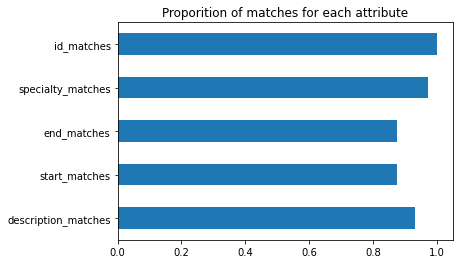

In [ ]:
def field_matches(field_name):
    return lambda df: (df[field_name + '_hl7'] == df[field_name + '_firestore']) | df[field_name + '_hl7'].isnull()

appointments_to_update = get_appointments().query("_merge == 'both'").assign(
    description_matches = field_matches('description'),
    start_matches = field_matches('start'),
    end_matches = field_matches('end'),
    specialty_matches = field_matches('specialty'),
    id_matches = lambda appointments: (appointments.appointment_id == appointments.fhirId) # should match if join key
)
appointments_to_update['all_fields_match'] = \
    appointments_to_update.description_matches &\
    appointments_to_update.start_matches &\
    appointments_to_update.end_matches &\
    appointments_to_update.specialty_matches &\
    appointments_to_update.id_matches

print('There are {} appointments in both hl7 and Firestore'.format(len(appointments_to_update)))
appointments_to_update[[c for c in appointments_to_update.columns if c.endswith("_matches")]].mean().plot.barh()
plt.title('Proporition of matches for each attribute')
# print("{} appointments do not have a specialty, so will not be mapped over")
appointments_to_update = appointments_to_update.query('not all_fields_match')
print('There are {} appointments which have differing details and need to be updated'.format(len(appointments_to_update)))
appointments_to_update.sample(10)#[['description_hl7', 'description_firestore', 'description_matches', 'new_description_matches']]

In [ ]:
for _, appointment in appointments_to_update.iterrows():
    appointment_data = dict(
        description=appointment.description_hl7,
        start=appointment.start_hl7,
        end=appointment.end_hl7,
        specialty=appointment.specialty_hl7,
        specialties=[appointment.specialty_hl7],
        # lastUpdated=firestore.SERVER_TIMESTAMP, # should this be 'updatedAt'?
        updatedAt=firestore.SERVER_TIMESTAMP,
        fhirId=appointment.fhirId,
        organisationId=organisationId
    )
    print(appointment_data)
    doc = store.collection('patients').document(appointment.patientId_hl7).collection('appointments').document(appointment.id).get()
    if doc.exists:
      store.collection('patients').document(appointment.patientId_hl7).collection('appointments').document(appointment.id).update(appointment_data)

{'description': '', 'start': Timestamp('2021-07-15 10:30:00+0000', tz='UTC'), 'end': Timestamp('2021-07-15 10:45:00+0000', tz='UTC'), 'specialty': '330', 'specialties': ['330'], 'updatedAt': Sentinel: Value used to set a document field to the server timestamp., 'fhirId': '62203881', 'organisationId': '3onsSeHQkSEiTTBxFL96'}
{'description': '', 'start': Timestamp('2021-04-22 09:30:00+0000', tz='UTC'), 'end': Timestamp('2021-04-22 10:00:00+0000', tz='UTC'), 'specialty': '400', 'specialties': ['400'], 'updatedAt': Sentinel: Value used to set a document field to the server timestamp., 'fhirId': '62266825', 'organisationId': '3onsSeHQkSEiTTBxFL96'}
{'description': 'Chrystalla Macedo', 'start': Timestamp('2021-04-07 11:00:00+0000', tz='UTC'), 'end': Timestamp('2021-04-07 11:15:00+0000', tz='UTC'), 'specialty': '330', 'specialties': ['330'], 'updatedAt': Sentinel: Value used to set a document field to the server timestamp., 'fhirId': '62252279', 'organisationId': '3onsSeHQkSEiTTBxFL96'}
{'des